In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import torch
import numpy as np
import pandas as pd
import glob

from pandas import DataFrame
from IPython.display import HTML
#HTML(DataFrame(MYDATA).to_html())
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

import sys
sys.path.append('/home/maghoi/fastai/old/')
sys.path.append('/home/maghoi/fastai/old/fastai_v7')
sys.path.append('/home/maghoi/fastai/')


from fastai_v7.imports import *
from fastai_v7.structured import *
from fastai.tabular import * 

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#from fastai.imports import *
#from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from plotnine import *

set_plot_sizes(12,14,16)

In [2]:
!ls /scratch/maghoi/pMHC_data/features6/

ls: cannot access '/scratch/maghoi/pMHC_data/features6/': No such file or directory


In [3]:
p0 = glob("/scratch/maghoi/pMHC_data/features6/*0p*")
p1 = glob("/scratch/maghoi/pMHC_data/features6/*1p*")
p2 = glob("/scratch/maghoi/pMHC_data/features6/*2p*")
p3 = glob("/scratch/maghoi/pMHC_data/features6/*3p*")
p4 = glob("/scratch/maghoi/pMHC_data/features6/*4p*")

train = p0 + p1 + p2
valid = p3
test = p4


### Pre-proc

In [63]:
df_raw[0:1]

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
key_0,,,,,,,,,,,,,,,,,,,,,
1g6r_1p_P1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4


In [37]:
df_raw = pd.read_csv("/home/maghoi/main/data/complexes.csv", low_memory=False)
all_energy = pd.read_csv("/home/maghoi/main/data/All_Energy.csv", low_memory = False)
df_raw = df_raw.drop("Unnamed: 0", axis = 1)

#set index to first column then drop it
df_raw = df_raw.set_index(df_raw.iloc[:,0]).drop("key_0", axis = 1)
all_energy = all_energy.set_index(all_energy.iloc[:,0]).drop("Unnamed: 0", axis = 1)
all_energy.rename(columns = {"Unnamed: 0": "key_0"}, inplace = True)
all_energy.index.name = "key_0"
df_raw.index.name = "key_0"

# Including only and removing peptide
df_raw_pep = df_raw.copy() #already contains y_true
df_raw_nopep = df_raw.copy() #already contains y_true
df_raw_energy = all_energy.copy() #need to add y_true


#Create column of zeroes (negative complexes)
zeroes = np.zeros((len(df_raw_energy),1))
zeroes = pd.DataFrame(zeroes).set_index(df_raw_energy.index)

#Merge zeroes on the right of complex_df
df = pd.merge(df_raw_energy, zeroes, on = df_raw_energy.index);
df = df.rename(columns={0 : "y_true"})

#Change zero to 1 (true complex) for all true complexes
changes = df[df.iloc[:,0].str.contains("_P")].index
df.loc[changes, "y_true"] = 1

df_raw_energy = df.copy(deep = False)

In [31]:
#Merge raw all
df_raw_energy = df_raw_energy.set_index(df_raw_energy.iloc[:,0]).drop("key_0", axis = 1)
df_raw_all = pd.merge(df_raw.drop("y_true", axis = 1), df_raw_energy, on = df_raw.index)
df_raw_all = df_raw_all.set_index(df_raw_all.key_0).drop("key_0", axis = 1)

# Remove peptide blosum scores in df_raw_nopep and raw_all_nopep
df_raw_pep.iloc[:,0:181] = np.zeros(shape = (1464,181))
df_raw_pep.iloc[:,192:468] = np.zeros(shape = (1464,276))

df_raw_nopep.iloc[:,181:192] = np.zeros(shape = (1464,11))

#Raw all nopep
df_raw_all_nopep = df_raw_all.copy(deep = False)
df_raw_all_nopep.iloc[:,180:191] = np.zeros(shape = (1464,11))




### Datasets

In [32]:
df_raw, y, nas = proc_df(df_raw, "y_true")
df_raw_pep, y, nas =  proc_df(df_raw_pep, "y_true")
df_raw_nopep, y, nas = proc_df(df_raw_nopep, "y_true")
df_raw_energy, y, nas = proc_df(df_raw_energy, "y_true")
df_raw_all, y, nas = proc_df(df_raw_all, "y_true")
df_raw_all_nopep, y, nas = proc_df(df_raw_all_nopep, "y_true")


### Setting up RF

In [33]:
dfs, ys, names = [df_raw, df_raw_pep, df_raw_nopep, df_raw_energy, df_raw_all, df_raw_all_nopep], [y, y, y, y, y, y], ["df_raw", "df_raw_pep", "df_raw_nopep", "df_raw_energy", "df_raw_all", "df_raw_all_nopep"]


In [8]:
df, y = df_raw, y

### Set train, val, test by partitions

In [9]:
p0 = df_raw.index.str.contains("0p")
p1 = df_raw.index.str.contains("1p")
p2 = df_raw.index.str.contains("2p")
p3 = df_raw.index.str.contains("3p")
p4 = df_raw.index.str.contains("4p")

X_train = df_raw[p0 + p1 + p2 + p3]
y_train = y[p0 + p1 + p2 + p3]

X_valid = df_raw[p4]
y_valid = y[p4]

In [10]:
len(X_train), len(y_train), len(X_valid), len(y_valid)

(1200, 1200, 264, 264)

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = int(len(df) / 5)  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1172, 468), (1172,), (292, 468))

In [12]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

class color:
    BOLD = '\033[1m'
    END = '\033[0m'

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    print(color.BOLD, "MCC:", round(metrics.matthews_corrcoef(y_valid, y_hat), 5), "\tAP:",  round(metrics.average_precision_score(y_valid, y_hat), 5), color.END)
    print(color.BOLD, "TPR:", round(tp/(tp+fn), 5), "\tTNR:", round(tn/(fp+tn), 5), color.END)
    print("Confusion matrix (tn, fp, fn, tp): \n", metrics.confusion_matrix(y_valid, y_hat))
    
    #print("1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_")
    print(res[0:2], res[4:], "RMSE x/y t/v, oob_score")
    print(res[2:4], "R^2 x/y train/valid")
    
def quick_print(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    mcc = round(metrics.matthews_corrcoef(y_valid, y_hat), 5)
    ap = round(metrics.average_precision_score(y_valid, y_hat), 5)
    tpr = round(tp/(tp+fn), 5)
    tnr = round(tn/(fp+tn), 5)
    
    print(color.BOLD, "MCC:", mcc, "\tAP:", ap, color.END)
    print(color.BOLD, "TPR:", tpr, "\tTNR:", tnr, color.END)
    
    values = [mcc, ap, tpr, tnr]
    return values

def no_print(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    mcc = round(metrics.matthews_corrcoef(y_valid, y_hat), 5)
    ap = round(metrics.average_precision_score(y_valid, y_hat), 5)
    tpr = round(tp/(tp+fn), 5)
    tnr = round(tn/(fp+tn), 5)
    
    values = [mcc, ap, tpr, tnr]
    return values
    
    

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef, average_precision_score 
def record_stats(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
            m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
        
    #Pairwise comparison
    y_scores = np.array(m.predict(X_valid))
    y_true = np.array(y_valid)
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = y_scores_binary == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    f1 = f1_score(y_true, y_scores_binary, average="binary")
    avp = average_precision_score(y_true, y_scores)

    correct = round(sum(correct) / len(y_true), 3)
    auc = round(auc, 3)
    mcc = round(mcc, 3)
    f1 = round(f1, 3)
    avp = round(avp, 3)

    confusion = metrics.confusion_matrix(y_true, y_scores_binary)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_scores_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    tpr = round(tpr, 3)
    tnr = round(tnr, 3)
    precision = round(precision, 3)
    recall = round(recall, 3)
    
    return(correct, auc, mcc, f1, avp, tpr, tnr, precision, recall, confusion, y_scores, y_scores_binary, y_true)

In [14]:
def stat_graphs(m):
    # Compute ROC curve and ROC area for each class
    y_scores = np.array(m.predict(X_valid))
    y_true = np.array(y_valid)
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    plt.scatter(y_scores, y_true, alpha=0.1) #Features 9 on parittions

    fpr = dict()
    tpr = dict()

    y_true=np.array(y_true)
    roc_auc = dict()
    fpr[0], tpr[0], steps = roc_curve(y_true, y_scores, pos_label=1, drop_intermediate=False)
    roc_auc[0] = auc(fpr[0], tpr[0])

    #Shared weights
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
stat_graphs(m)

NameError: name 'm' is not defined

### Partition RF

In [16]:
set_rf_samples(int((10/10)*len(X_train))) #Random forest samples from all of rows (performs better)
m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

 MCC: 0.85883 	AP: 0.8085 
 TPR: 0.77083 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[244   0]
 [ 11  37]]
[0.04676628304053444, 0.21951445572200584] [0.8819738521903147] RMSE x/y t/v, oob_score
[0.9842958280477492, 0.6491989460003035] R^2 x/y train/valid


In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score
from sklearn import random_projection
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

In [18]:
def stats(y_hat, y_true):
    #Pairwise comparison
    yhat = np.array(y_hat)
    y_true = np.array(y_true)
    yhat_binary = np.where(y_hat > 0.5, 1, 0)

    correct = yhat_binary == y_true
    auc = roc_auc_score(y_true, yhat)
    mcc = matthews_corrcoef(y_true, yhat_binary)
    avp = average_precision_score(y_true, yhat)

    print("Correct:", round(sum(correct) / len(y_true), 3))
    print("AUC", round(auc, 3))
    print("MCC", round(mcc, 3))
    print("AVP", round(avp, 3))

    print("\nTn, fp, fn, tp")
    print(metrics.confusion_matrix(y_true, yhat_binary))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    print("TPR:", round(tpr, 3))
    print("TNR:", round(tnr, 3))


In [19]:
y_pred = m.predict(X_valid)
y_true = y_valid
stats(y_pred, y_true)

Correct: 0.962
AUC 0.963
MCC 0.859
AVP 0.916

Tn, fp, fn, tp
[[244   0]
 [ 11  37]]
TPR: 0.771
TNR: 1.0


### Quick RF

In [313]:
for df, y, name in zip(dfs, ys, names):
    df_trn, y_trn = df, y
    
    n_valid = int(len(df) / 6) # validation = 1/6th of set
    n_trn = len(df)-n_valid
    X_train, X_valid = split_vals(df, n_trn)
    y_train, y_valid = split_vals(y, n_trn)
    print("\n ### Set:", name)
    print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)
    
    set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)
    
    
    m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)


 ### Set: df_raw
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.86154 	AP: 0.81189 
 TPR: 0.775 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [  9  31]]
[0.036721580835923355, 0.21039214946707743] [0.8933927175274798] RMSE x/y t/v, oob_score
[0.9903163624920658, 0.6770401348039216] R^2 x/y train/valid

 ### Set: df_raw_nopep
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.41579 	AP: 0.33115 
 TPR: 0.2 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 32   8]]
[0.31135227282525196, 0.3470906785315443] [-0.004143035135086848] RMSE x/y t/v, oob_score
[0.30385474596760076, 0.12102728337549394] R^2 x/y train/valid

 ### Set: df_raw_energy
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16393 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 40   0]]
[0.09054329037368804, 0.3425522476203109] [0.3696655930544245] RMSE x/y t/v, oob_score
[0.9411280621172353, 0.1438632557189541] R^2 x/y train/valid

 ### Set: df_raw_all
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 36   4]]
[0.07869936860806338, 0.30182024062390717] [0.5040298395467406] RMSE x/y t/v, oob_score
[0.955522713651296, 0.33536039624183] R^2 x/y train/valid

 ### Set: df_raw_all_nopep
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 36   4]]
[0.08492603660826914, 0.3189141377100264] [0.4189222816070707] RMSE x/y t/v, oob_score
[0.9482062329524986, 0.25794338916121995] R^2 x/y train/valid


### Cross-validation

In [21]:
def cross_vals(df, n_trn, i): 
    start = n_valid*i
    end = n_valid*(i+1)
    train = np.append(df[0:start], df[end:], axis = 0).copy()
    valid = df[start:end].copy()
    
    #print("Valid:", start, end)
    return(train, valid)

In [26]:
partitions = [0, 1, 2, 3, 4]
values = []

for df, y, name in zip(dfs, ys, names):
    print("\n-------------\n")
    for i in partitions:
        print("\nSet:", name, "run", i+1, "of", partitions[-1]+1)
        
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid

        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)

        set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        print_score(m)
        
        values.append(record_stats(m)[:-3])
        #print("Set:", name, "run", i, "of", partitions[-1]+1, values[-1])
        #print(stat_graphs(m))

    output = pd.DataFrame(values)
    output.columns = ["Correc", "AUC", "MCC", "F1", "AVP", "TPR", "TNR", "Prec", "Rec", "Confusion"]
    print("\n", name, "\n",output.describe())


-------------


Set: df_raw run 1 of 5
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.83203 	AP: 0.77146 
 TPR: 0.78049 	TNR: 0.99015 
Confusion matrix (tn, fp, fn, tp): 
 [[201   2]
 [  9  32]]
[0.032748420059499704, 0.225542858580063] [0.9486067963153407] RMSE x/y t/v, oob_score
[0.9922681507960727, 0.6361202237441093] R^2 x/y train/valid

Set: df_raw run 2 of 5
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.88273 	AP: 0.83079 
 TPR: 0.90244 	TNR: 0.9803 
Confusion matrix (tn, fp, fn, tp): 
 [[199   4]
 [  4  37]]
[0.03724530996990223, 0.15630524524258962] [0.9349233121588442] RMSE x/y t/v, oob_score
[0.9899989440593652, 0.8252380578584111] R^2 x/y train/valid

Set: df_raw run 3 of 5
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.95477 	AP: 0.9373 
 TPR: 0.925 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [  3  37]]
[0.03177906426122017, 0.1574280996435422] [0.9514520600721661] RMSE x/y t/v, 

### Quick-print

In [316]:
output = ""
partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    print("-------------")
    for i in partitions:
        print("\nSet:", name, "run", i+1, "of", partitions[-1]+1)
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid
        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        
        quick_print(m)
        
        
        
        

-------------

Set: df_raw run 1 of 6
 MCC: 0.79955 	AP: 0.73106 
 TPR: 0.73171 	TNR: 0.99015 

Set: df_raw run 2 of 6
 MCC: 0.94074 	AP: 0.91883 
 TPR: 0.90244 	TNR: 1.0 

Set: df_raw run 3 of 6
 MCC: 0.84459 	AP: 0.78767 
 TPR: 0.775 	TNR: 0.9951 

Set: df_raw run 4 of 6
 MCC: 0.83312 	AP: 0.77679 
 TPR: 0.73171 	TNR: 1.0 

Set: df_raw run 5 of 6
 MCC: 0.83312 	AP: 0.77679 
 TPR: 0.73171 	TNR: 1.0 

Set: df_raw run 6 of 6
 MCC: 0.84555 	AP: 0.79098 
 TPR: 0.75 	TNR: 1.0 
-------------

Set: df_raw_nopep run 1 of 6
 MCC: 0.18354 	AP: 0.20852 
 TPR: 0.12195 	TNR: 0.97537 

Set: df_raw_nopep run 2 of 6
 MCC: 0.52282 	AP: 0.42937 
 TPR: 0.36585 	TNR: 0.99015 

Set: df_raw_nopep run 3 of 6
 MCC: 0.21383 	AP: 0.22004 
 TPR: 0.2 	TNR: 0.95098 

Set: df_raw_nopep run 4 of 6
 MCC: 0.50606 	AP: 0.41154 
 TPR: 0.29268 	TNR: 1.0 

Set: df_raw_nopep run 5 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_nopep run 6 of 6
 MCC: 0.41579 	AP: 0.33115 
 TPR: 0.2 	TNR: 1.0 
------

/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 2 of 6
 MCC: 0.14274 	AP: 0.18832 
 TPR: 0.02439 	TNR: 1.0 

Set: df_raw_energy run 3 of 6
 MCC: 0.2053 	AP: 0.20574 
 TPR: 0.05 	TNR: 1.0 

Set: df_raw_energy run 4 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 5 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 6 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16393 
 TPR: 0.0 	TNR: 1.0 
-------------

Set: df_raw_all run 1 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_all run 2 of 6
 MCC: 0.50606 	AP: 0.41154 
 TPR: 0.29268 	TNR: 1.0 

Set: df_raw_all run 3 of 6
 MCC: 0.32664 	AP: 0.26844 
 TPR: 0.125 	TNR: 1.0 

Set: df_raw_all run 4 of 6
 MCC: 0.24826 	AP: 0.22891 
 TPR: 0.07317 	TNR: 1.0 

Set: df_raw_all run 5 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_all run 6 of 6
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
-------------

Set: df_raw_all_nopep run 1 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_all_nopep run 2 of 6
 MCC: 0.45999 	AP: 0.37095 
 TPR: 0.2439 	TNR: 1.0 

Set: df_raw_all_nopep run 3 of 6
 MCC: 0.25196 	AP: 0.22664 
 TPR: 0.075 	TNR: 1.0 

Set: df_raw_all_nopep run 4 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_all_nopep run 5 of 6
 MCC: 0.14274 	AP: 0.18832 
 TPR: 0.02439 	TNR: 1.0 

Set: df_raw_all_nopep run 6 of 6
 MCC: 0.32664 	AP: 0.26844 
 TPR: 0.125 	TNR: 1.0 


### Noprint

In [ ]:
    return(correct, auc, mcc, f1, avp, tpr, tnr, precision, recall, confusion, y_scores, y_scores_binary, y_true)

In [143]:
p0 = df_raw.index.str.contains("0p")
p1 = df_raw.index.str.contains("1p")
p2 = df_raw.index.str.contains("2p")
p3 = df_raw.index.str.contains("3p")
p4 = df_raw.index.str.contains("4p")

X_train = df_raw[p0 + p1 + p2 + p3]
y_train = y[p0 + p1 + p2 + p3]

X_valid = df_raw[p4]
y_valid = y[p4]



#### Actual partitions random forest analysis

df_raw

Run 1 / 5 ... Val 0 Train 1234
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 0 of 5 (0.938, 0.903, 0.761, 0.788, 0.813, 0.696, 0.986, 0.907, 0.696, array([[276,   4],
       [ 17,  39]]))


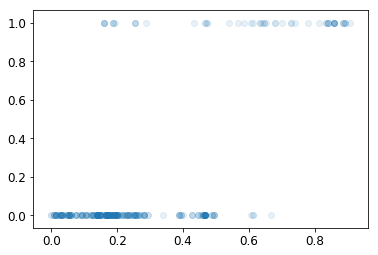

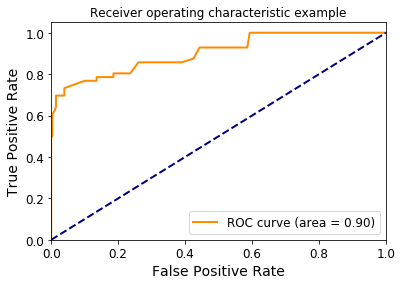

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw run 1 of 5 (0.888, 0.891, 0.533, 0.545, 0.715, 0.404, 0.985, 0.84, 0.404, array([[256,   4],
       [ 31,  21]]))


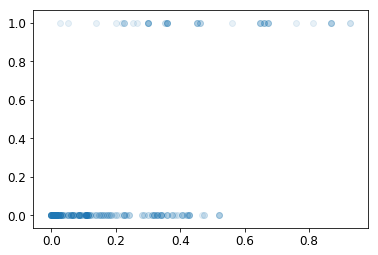

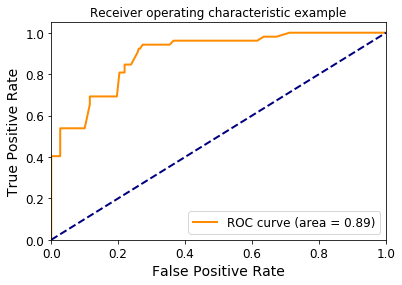

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 2 of 5 (0.896, 0.956, 0.71, 0.75, 0.94, 0.938, 0.888, 0.625, 0.938, array([[213,  27],
       [  3,  45]]))


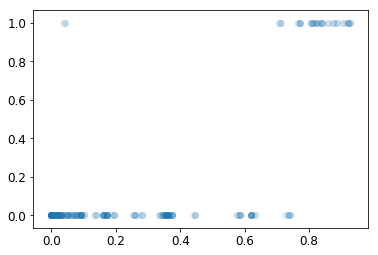

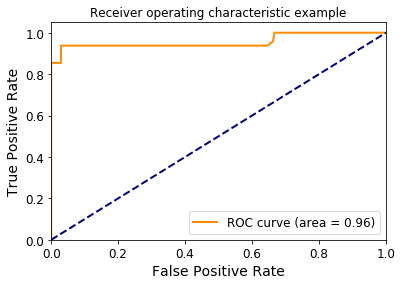

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 3 of 5 (0.807, 0.853, 0.111, 0.19, 0.512, 0.136, 0.941, 0.316, 0.136, array([[207,  13],
       [ 38,   6]]))


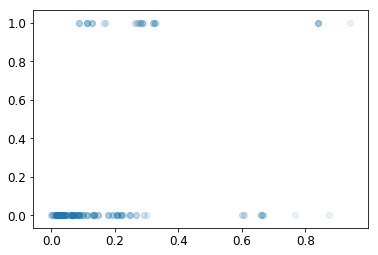

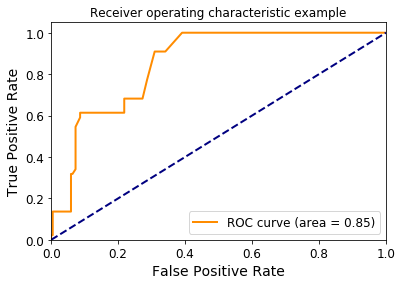

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw run 4 of 4 (0.936, 0.857, 0.755, 0.761, 0.747, 0.614, 1.0, 1.0, 0.614, array([[220,   0],
       [ 17,  27]]))


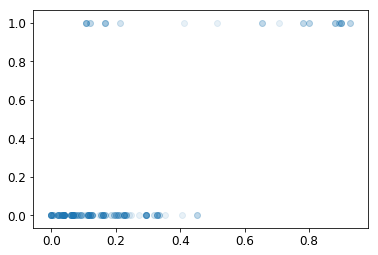

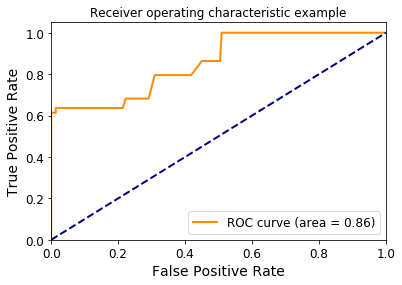

None

 df_raw 
         Correc       AUC       MCC        F1       AVP       TPR       TNR  \
count  5.00000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.89300  0.892000  0.574000  0.606800  0.745400  0.557600  0.960000   
std    0.05316  0.041725  0.274898  0.252319  0.156398  0.303471  0.045951   
min    0.80700  0.853000  0.111000  0.190000  0.512000  0.136000  0.888000   
25%    0.88800  0.857000  0.533000  0.545000  0.715000  0.404000  0.941000   
50%    0.89600  0.891000  0.710000  0.750000  0.747000  0.614000  0.985000   
75%    0.93600  0.903000  0.755000  0.761000  0.813000  0.696000  0.986000   
max    0.93800  0.956000  0.761000  0.788000  0.940000  0.938000  1.000000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.737600  0.557600  
std    0.273158  0.303471  
min    0.316000  0.136000  
25%    0.625000  0.404000  
50%    0.840000  0.614000  
75%    0.907000  0.696000  
max    1.000000  0.938000  
df_raw_pep

Run 1 / 5 ... Val

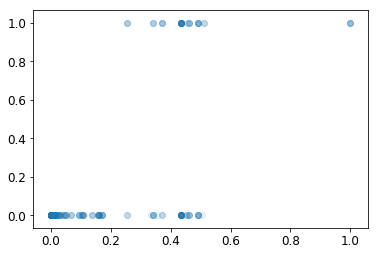

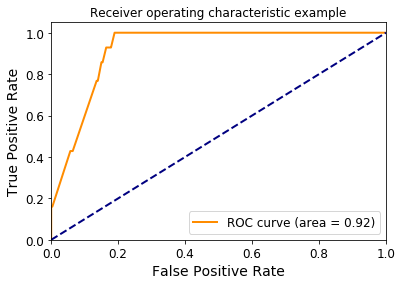

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw_pep run 1 of 5 (0.821, 0.786, 0.28, 0.378, 0.447, 0.327, 0.919, 0.447, 0.327, array([[239,  21],
       [ 35,  17]]))


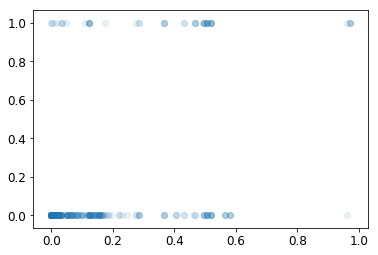

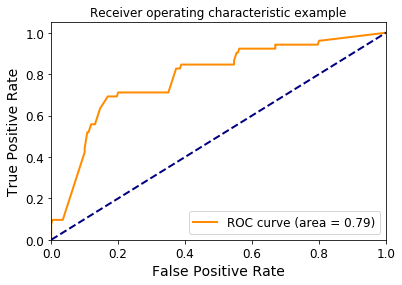

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_pep run 2 of 5 (0.872, 0.927, 0.565, 0.641, 0.728, 0.688, 0.908, 0.6, 0.688, array([[218,  22],
       [ 15,  33]]))


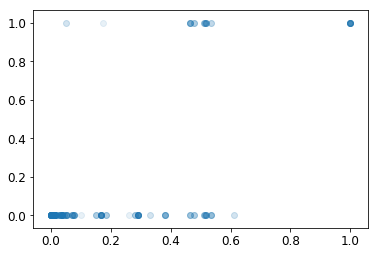

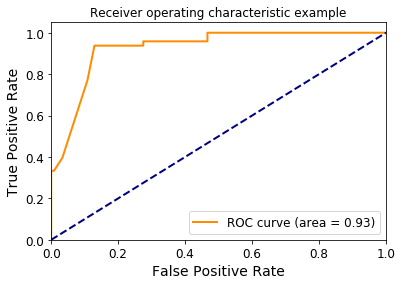

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_pep run 3 of 5 (0.822, 0.805, 0.279, 0.373, 0.409, 0.318, 0.923, 0.452, 0.318, array([[203,  17],
       [ 30,  14]]))


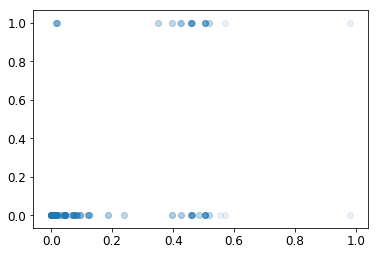

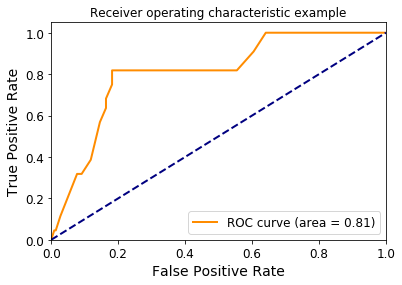

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_pep run 4 of 4 (0.848, 0.832, 0.384, 0.459, 0.532, 0.386, 0.941, 0.567, 0.386, array([[207,  13],
       [ 27,  17]]))


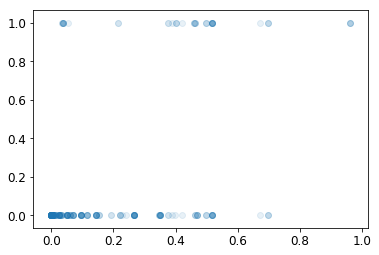

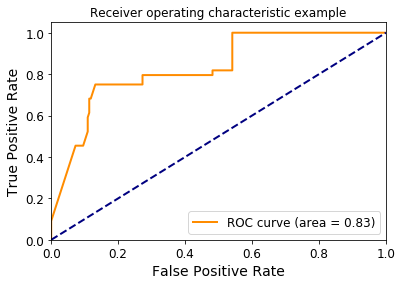

None

 df_raw_pep 
         Correc       AUC     MCC        F1      AVP       TPR       TNR  \
count  5.00000  5.000000  5.0000  5.000000  5.00000  5.000000  5.000000   
mean   0.84400  0.854200  0.3706  0.424800  0.54960  0.376000  0.937400   
std    0.02226  0.065816  0.1175  0.137685  0.13155  0.193283  0.034847   
min    0.82100  0.786000  0.2790  0.273000  0.40900  0.161000  0.908000   
25%    0.82200  0.805000  0.2800  0.373000  0.44700  0.318000  0.919000   
50%    0.84800  0.832000  0.3450  0.378000  0.53200  0.327000  0.923000   
75%    0.85700  0.921000  0.3840  0.459000  0.63200  0.386000  0.941000   
max    0.87200  0.927000  0.5650  0.641000  0.72800  0.688000  0.996000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.593200  0.376000  
std    0.184507  0.193283  
min    0.447000  0.161000  
25%    0.452000  0.318000  
50%    0.567000  0.327000  
75%    0.600000  0.386000  
max    0.900000  0.688000  
df_raw_nopep

Run 1 / 5 ... Val 0 Train 1234
1g6r_1p

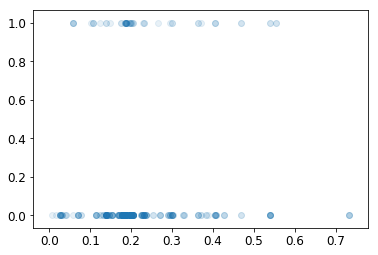

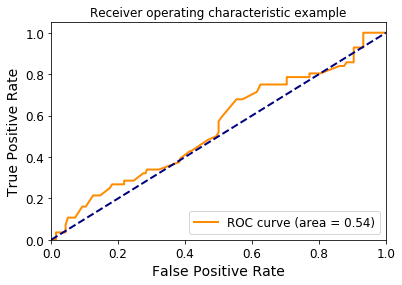

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw_nopep run 1 of 5 (0.824, 0.544, 0.011, 0.035, 0.191, 0.019, 0.985, 0.2, 0.019, array([[256,   4],
       [ 51,   1]]))


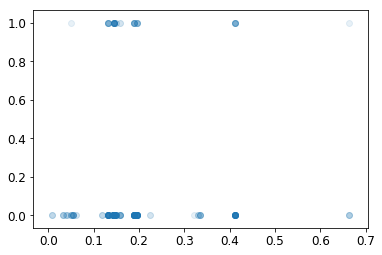

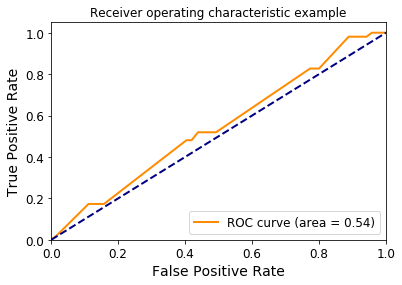

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_nopep run 2 of 5 (0.823, 0.539, 0.105, 0.136, 0.205, 0.083, 0.971, 0.364, 0.083, array([[233,   7],
       [ 44,   4]]))


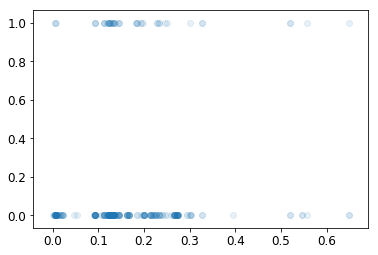

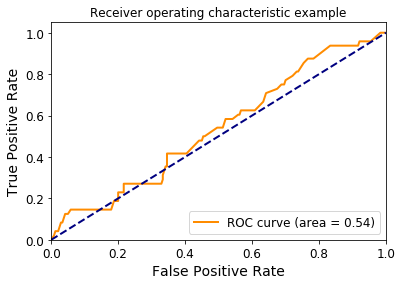

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_80s_pMHC-TCR


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


Set: df_raw_nopep run 3 of 5 (0.833, 0.617, 0.0, 0.0, 0.239, 0.0, 1.0, nan, 0.0, array([[220,   0],
       [ 44,   0]]))


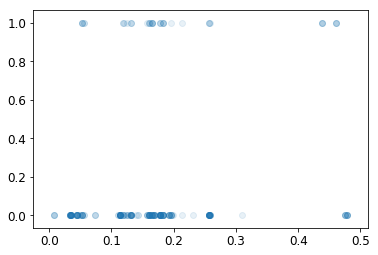

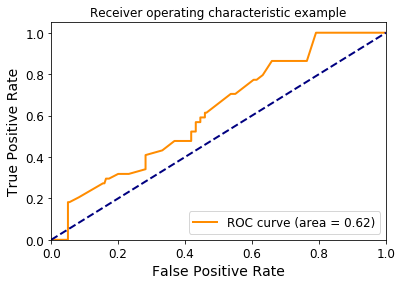

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_nopep run 4 of 4 (0.72, 0.605, 0.043, 0.213, 0.205, 0.227, 0.818, 0.2, 0.227, array([[180,  40],
       [ 34,  10]]))


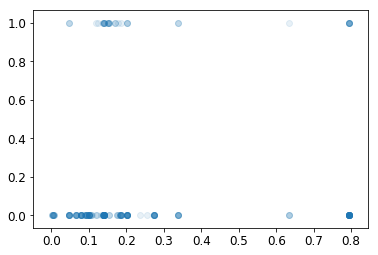

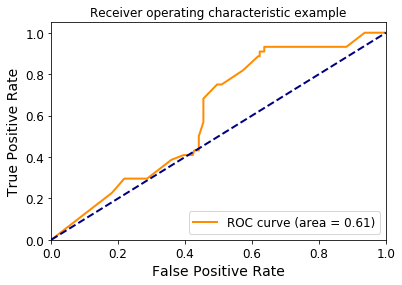

None

 df_raw_nopep 
          Correc       AUC       MCC       F1      AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.00000  5.00000  5.000000  5.000000   
mean   0.802000  0.569400  0.041800  0.09900  0.20840  0.080000  0.946200   
std    0.046567  0.038253  0.041106  0.08427  0.01805  0.089191  0.073428   
min    0.720000  0.539000  0.000000  0.00000  0.19100  0.000000  0.818000   
25%    0.810000  0.542000  0.011000  0.03500  0.20200  0.019000  0.957000   
50%    0.823000  0.544000  0.043000  0.11100  0.20500  0.071000  0.971000   
75%    0.824000  0.605000  0.050000  0.13600  0.20500  0.083000  0.985000   
max    0.833000  0.617000  0.105000  0.21300  0.23900  0.227000  1.000000   

           Prec       Rec  
count  4.000000  5.000000  
mean   0.253500  0.080000  
std    0.077346  0.089191  
min    0.200000  0.000000  
25%    0.200000  0.019000  
50%    0.225000  0.071000  
75%    0.278500  0.083000  
max    0.364000  0.227000  
df_raw_energy

Run 1 / 5 ... Val

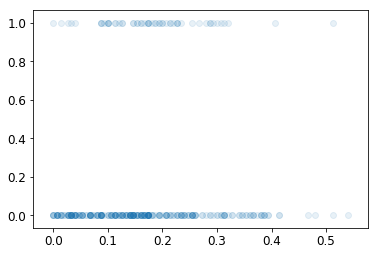

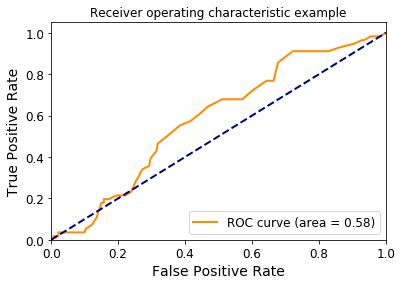

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_99s_pMHC-TCR
Set: df_raw_energy run 1 of 5 (0.827, 0.574, -0.036, 0.0, 0.193, 0.0, 0.992, 0.0, 0.0, array([[258,   2],
       [ 52,   0]]))


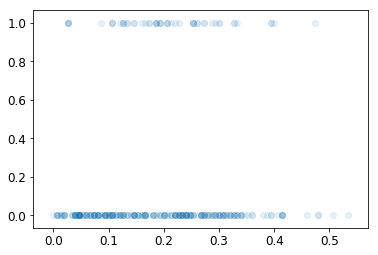

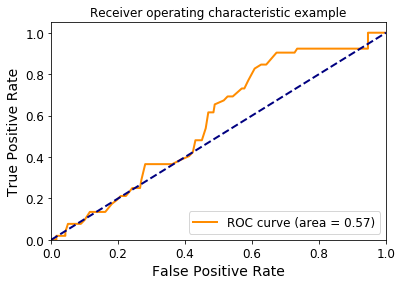

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_99s_pMHC-TCR
Set: df_raw_energy run 2 of 5 (0.83, 0.637, 0.046, 0.039, 0.229, 0.021, 0.992, 0.333, 0.021, array([[238,   2],
       [ 47,   1]]))


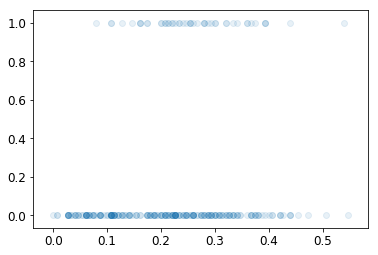

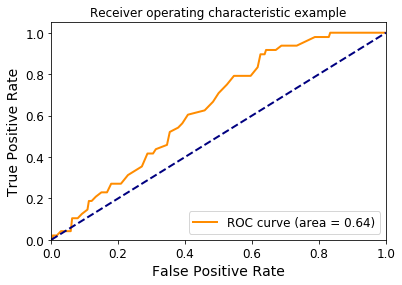

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_99s_pMHC-TCR
Set: df_raw_energy run 3 of 5 (0.788, 0.663, -0.06, 0.034, 0.264, 0.023, 0.941, 0.071, 0.023, array([[207,  13],
       [ 43,   1]]))


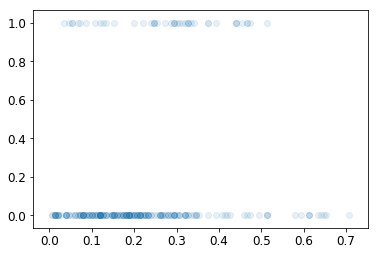

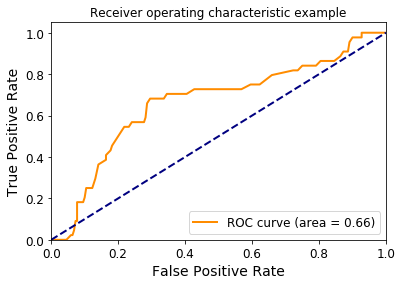

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_99s_pMHC-TCR
Set: df_raw_energy run 4 of 4 (0.83, 0.523, 0.048, 0.043, 0.205, 0.023, 0.991, 0.333, 0.023, array([[218,   2],
       [ 43,   1]]))


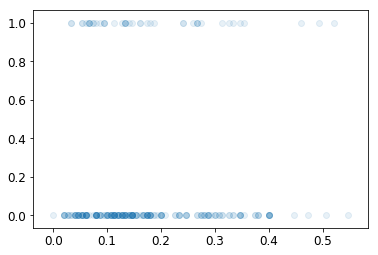

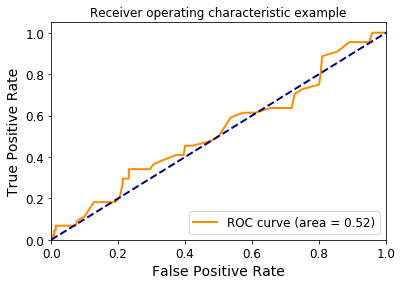

None

 df_raw_energy 
          Correc       AUC       MCC       F1       AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.00000  5.000000  5.000000  5.000000   
mean   0.821000  0.596400  0.008000  0.03000  0.217400  0.017000  0.981800   
std    0.018493  0.055007  0.051865  0.01719  0.029636  0.009721  0.022819   
min    0.788000  0.523000 -0.060000  0.00000  0.193000  0.000000  0.941000   
25%    0.827000  0.574000 -0.036000  0.03400  0.196000  0.018000  0.991000   
50%    0.830000  0.585000  0.042000  0.03400  0.205000  0.021000  0.992000   
75%    0.830000  0.637000  0.046000  0.03900  0.229000  0.023000  0.992000   
max    0.830000  0.663000  0.048000  0.04300  0.264000  0.023000  0.993000   

          Prec       Rec  
count  5.00000  5.000000  
mean   0.21400  0.017000  
std    0.16487  0.009721  
min    0.00000  0.000000  
25%    0.07100  0.018000  
50%    0.33300  0.021000  
75%    0.33300  0.023000  
max    0.33300  0.023000  
df_raw_all

Run 1 / 5 ... Val 0

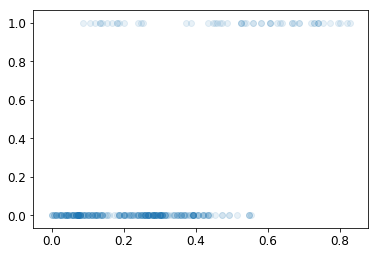

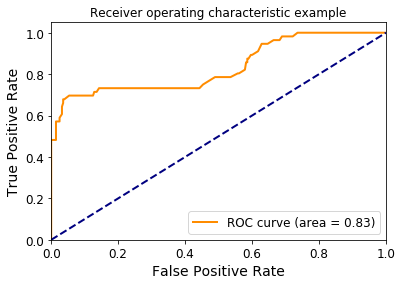

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw_all run 1 of 5 (0.891, 0.841, 0.553, 0.514, 0.701, 0.346, 1.0, 1.0, 0.346, array([[260,   0],
       [ 34,  18]]))


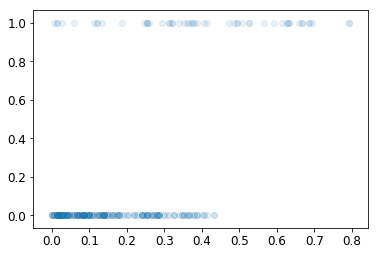

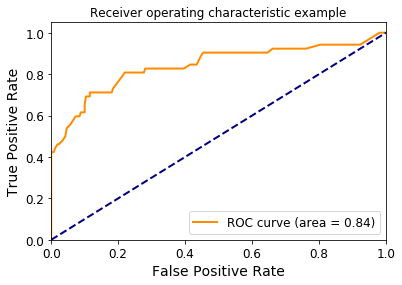

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all run 2 of 5 (0.854, 0.86, 0.44, 0.523, 0.66, 0.479, 0.929, 0.575, 0.479, array([[223,  17],
       [ 25,  23]]))


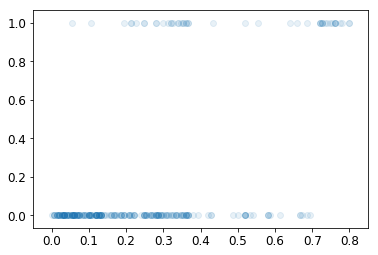

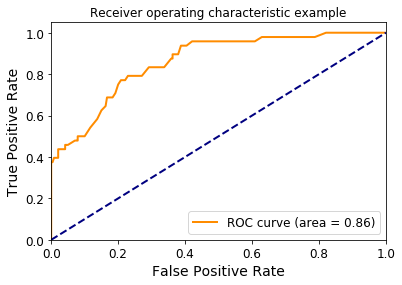

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all run 3 of 5 (0.811, 0.764, 0.099, 0.167, 0.395, 0.114, 0.95, 0.312, 0.114, array([[209,  11],
       [ 39,   5]]))


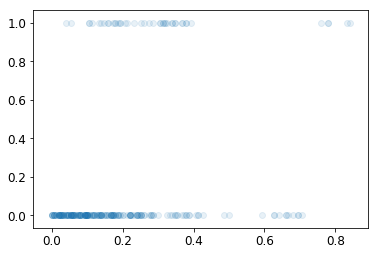

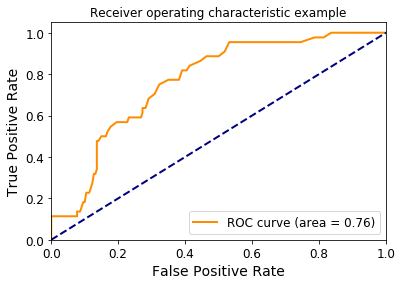

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all run 4 of 4 (0.864, 0.72, 0.395, 0.308, 0.528, 0.182, 1.0, 1.0, 0.182, array([[220,   0],
       [ 36,   8]]))


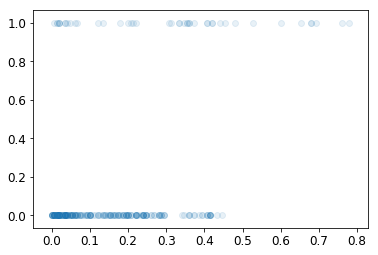

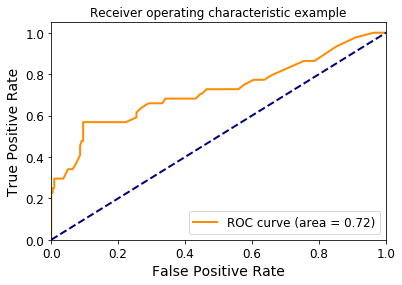

None

 df_raw_all 
          Correc       AUC       MCC        F1       AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.866800  0.803600  0.429200  0.440000  0.604800  0.338400  0.972200   
std    0.039047  0.059163  0.211218  0.203606  0.141858  0.192837  0.031626   
min    0.811000  0.720000  0.099000  0.167000  0.395000  0.114000  0.929000   
25%    0.854000  0.764000  0.395000  0.308000  0.528000  0.182000  0.950000   
50%    0.864000  0.833000  0.440000  0.514000  0.660000  0.346000  0.982000   
75%    0.891000  0.841000  0.553000  0.523000  0.701000  0.479000  1.000000   
max    0.914000  0.860000  0.659000  0.688000  0.740000  0.571000  1.000000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.750400  0.338400  
std    0.300289  0.192837  
min    0.312000  0.114000  
25%    0.575000  0.182000  
50%    0.865000  0.346000  
75%    1.000000  0.479000  
max    1.000000  0.571000  
df_raw_all_nopep

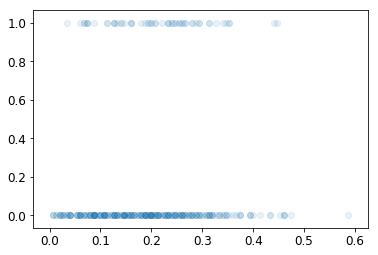

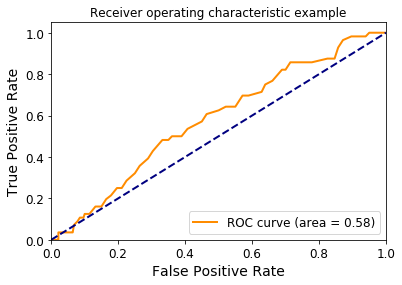

None

Run 2 / 5 ... Val 1 Train 0234
2bnq_2p_P1_1t_80s_pMHC-TCR
Set: df_raw_all_nopep run 1 of 5 (0.837, 0.629, 0.127, 0.038, 0.23, 0.019, 1.0, 1.0, 0.019, array([[260,   0],
       [ 51,   1]]))


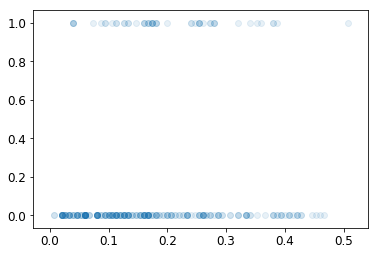

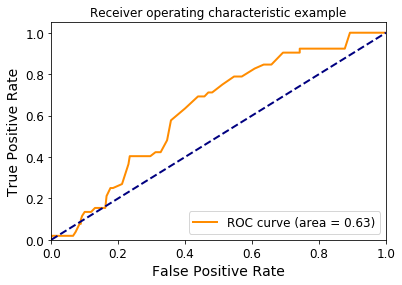

None

Run 3 / 5 ... Val 2 Train 0134
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all_nopep run 2 of 5 (0.844, 0.617, 0.232, 0.182, 0.28, 0.104, 0.992, 0.714, 0.104, array([[238,   2],
       [ 43,   5]]))


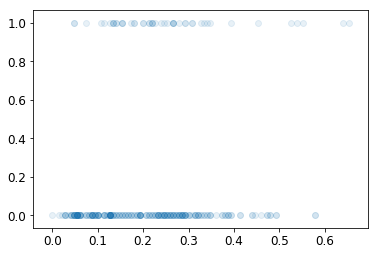

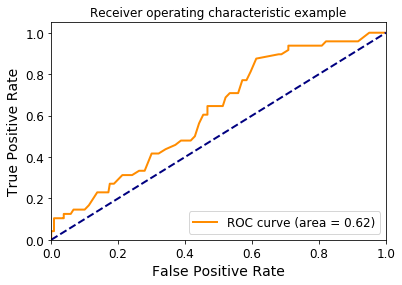

None

Run 4 / 5 ... Val 3 Train 0124
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all_nopep run 3 of 5 (0.788, 0.691, -0.098, 0.0, 0.253, 0.0, 0.945, 0.0, 0.0, array([[208,  12],
       [ 44,   0]]))


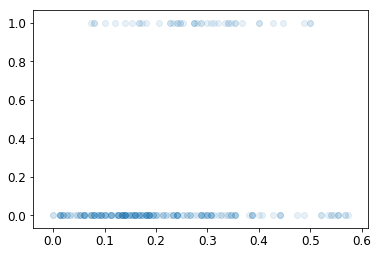

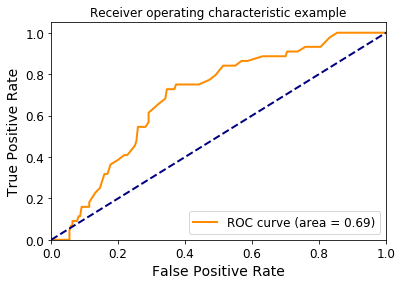

None

Run 5 / 5 ... Val 4 Train 0123
1g6r_1p_P1_1t_80s_pMHC-TCR
Set: df_raw_all_nopep run 4 of 4 (0.826, 0.602, -0.039, 0.0, 0.209, 0.0, 0.991, 0.0, 0.0, array([[218,   2],
       [ 44,   0]]))


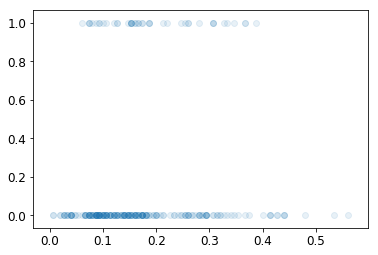

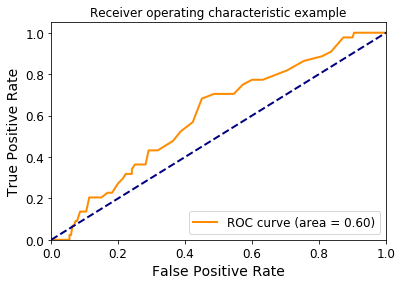

None

 df_raw_all_nopep 
          Correc       AUC       MCC       F1       AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.00000  5.000000  5.000000  5.000000   
mean   0.825000  0.623800  0.039600  0.04400  0.234000  0.024600  0.984800   
std    0.021794  0.041782  0.135843  0.07888  0.033219  0.045142  0.022532   
min    0.788000  0.580000 -0.098000  0.00000  0.198000  0.000000  0.945000   
25%    0.826000  0.602000 -0.039000  0.00000  0.209000  0.000000  0.991000   
50%    0.830000  0.617000 -0.024000  0.00000  0.230000  0.000000  0.992000   
75%    0.837000  0.629000  0.127000  0.03800  0.253000  0.019000  0.996000   
max    0.844000  0.691000  0.232000  0.18200  0.280000  0.104000  1.000000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.342800  0.024600  
std    0.480166  0.045142  
min    0.000000  0.000000  
25%    0.000000  0.000000  
50%    0.000000  0.000000  
75%    0.714000  0.019000  
max    1.000000  0.104000  


In [34]:
partitions = [0, 1, 2, 3, 4]
for df, y, name in zip(dfs, ys, names):
    print(name)
    
    #Cross-val function
    data = [p0, p1, p2, p3, p4]
    partitions = [0, 1, 2, 3, 4]
    run = 0

    values = []
    for i in partitions:
        partitions = [0, 1, 2, 3, 4]
        val_part = data[i]
        partitions.remove(i)

        train_part = [False]*1464
        train_i3 = []
        for i3 in partitions:
            train_part += data[i3]
            train_i3.append(i3)

        train_i3 = "".join(map(str, train_i3))
        run += 1
        print("\nRun", run, "/ 5 ...", "Val", i, "Train", train_i3)

        X_train = df[train_part]
        y_train = y[train_part]

        X_valid = df[val_part]
        y_valid = y[val_part]
        print(X_train.index[0])

        set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        values.append(record_stats(m)[:-3])
        print("Set:", name, "run", i, "of", partitions[-1]+1, values[-1])
        print(stat_graphs(m))

    output = pd.DataFrame(values)
    output.columns = ["Correc", "AUC", "MCC", "F1", "AVP", "TPR", "TNR", "Prec", "Rec", "Confusion"]
    print("\n", name, "\n",output.describe())

    

-------------
Set: df_raw run 0 of 5 (0.955, 0.957, 0.832, 0.853, 0.889, 0.78, 0.99, 0.941, 0.78, array([[201,   2],
       [  9,  32]]))


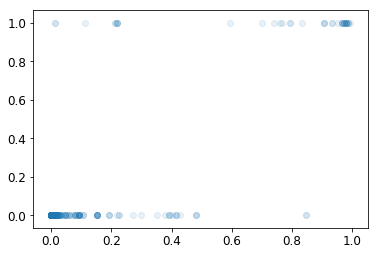

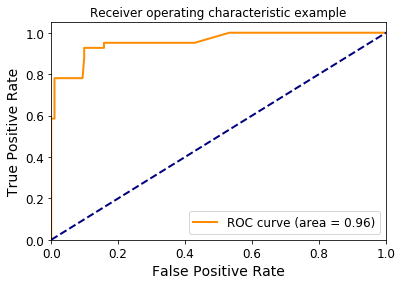

None
Set: df_raw run 1 of 5 (0.967, 0.976, 0.883, 0.902, 0.945, 0.902, 0.98, 0.902, 0.902, array([[199,   4],
       [  4,  37]]))


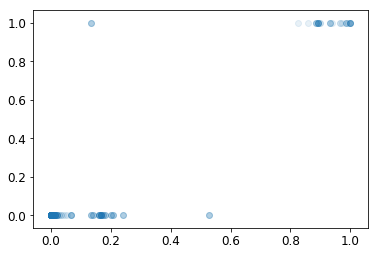

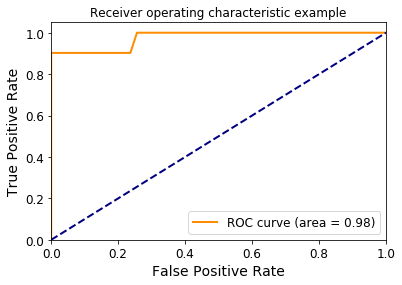

None
Set: df_raw run 2 of 5 (0.984, 0.983, 0.939, 0.949, 0.962, 0.925, 0.995, 0.974, 0.925, array([[203,   1],
       [  3,  37]]))


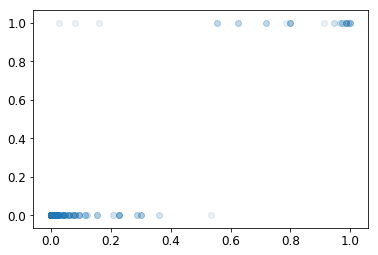

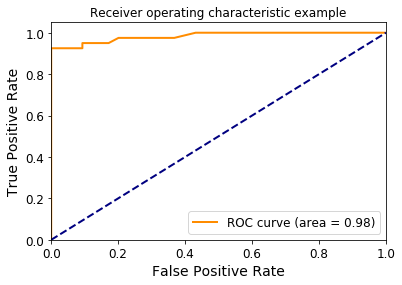

None
Set: df_raw run 3 of 5 (0.914, 0.973, 0.695, 0.747, 0.91, 0.756, 0.946, 0.738, 0.756, array([[192,  11],
       [ 10,  31]]))


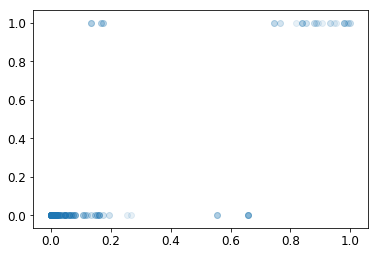

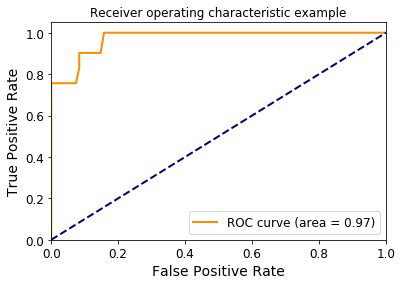

None
Set: df_raw run 4 of 5 (0.91, 0.977, 0.678, 0.732, 0.915, 0.732, 0.946, 0.732, 0.732, array([[192,  11],
       [ 11,  30]]))


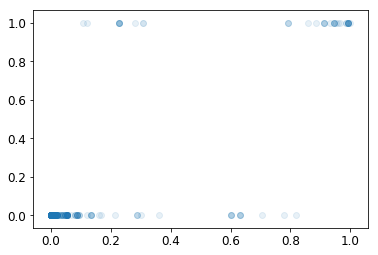

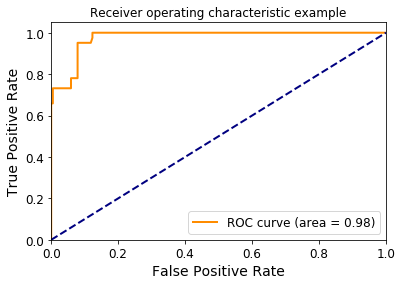

None

 df_raw 
          Correc       AUC       MCC        F1       AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.946000  0.973200  0.805400  0.836600  0.924200  0.819000  0.971400   
std    0.032734  0.009757  0.115106  0.095065  0.029098  0.088295  0.023808   
min    0.910000  0.957000  0.678000  0.732000  0.889000  0.732000  0.946000   
25%    0.914000  0.973000  0.695000  0.747000  0.910000  0.756000  0.946000   
50%    0.955000  0.976000  0.832000  0.853000  0.915000  0.780000  0.980000   
75%    0.967000  0.977000  0.883000  0.902000  0.945000  0.902000  0.990000   
max    0.984000  0.983000  0.939000  0.949000  0.962000  0.925000  0.995000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.857400  0.819000  
std    0.114625  0.088295  
min    0.732000  0.732000  
25%    0.738000  0.756000  
50%    0.902000  0.780000  
75%    0.941000  0.902000  
max    0.974000  0.925000  
-------------
Set: d

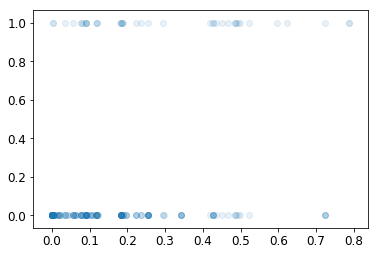

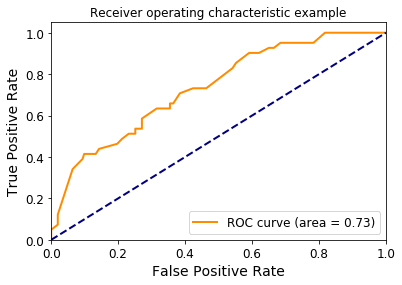

None
Set: df_raw_nopep run 1 of 5 (0.885, 0.831, 0.524, 0.5, 0.619, 0.341, 0.995, 0.933, 0.341, array([[202,   1],
       [ 27,  14]]))


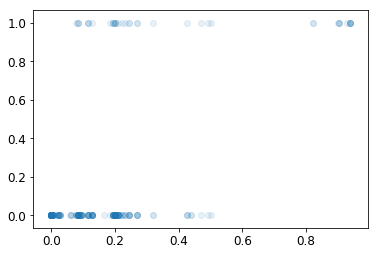

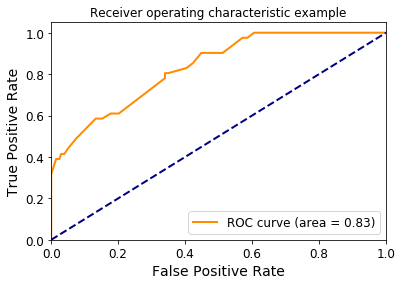

None
Set: df_raw_nopep run 2 of 5 (0.807, 0.72, 0.276, 0.39, 0.415, 0.375, 0.892, 0.405, 0.375, array([[182,  22],
       [ 25,  15]]))


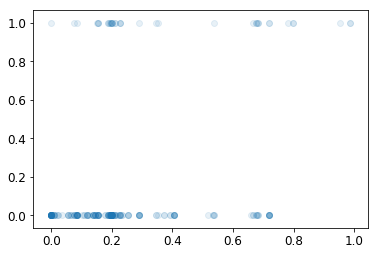

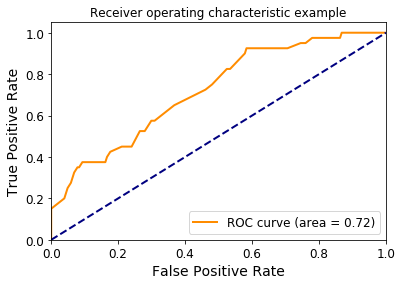

None
Set: df_raw_nopep run 3 of 5 (0.836, 0.777, 0.305, 0.375, 0.492, 0.293, 0.946, 0.522, 0.293, array([[192,  11],
       [ 29,  12]]))


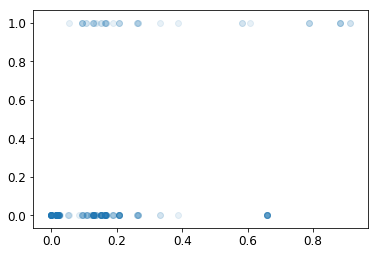

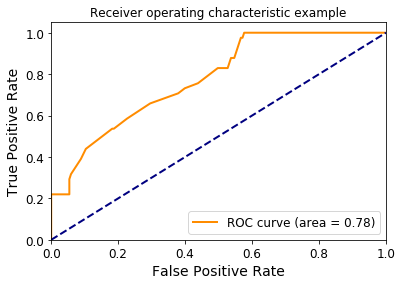

None
Set: df_raw_nopep run 4 of 5 (0.84, 0.613, 0.202, 0.093, 0.251, 0.049, 1.0, 1.0, 0.049, array([[203,   0],
       [ 39,   2]]))


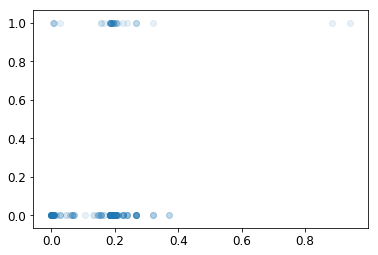

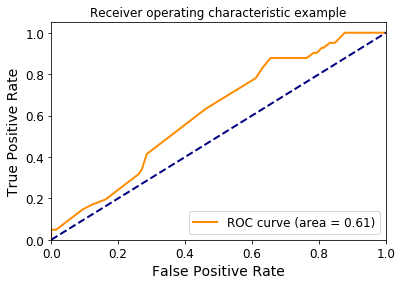

None

 df_raw_nopep 
         Correc       AUC       MCC        F1       AVP       TPR      TNR  \
count  5.00000  5.000000  5.000000  5.000000  5.000000  5.000000  5.00000   
mean   0.84080  0.735000  0.305200  0.317800  0.433400  0.240800  0.96160   
std    0.02803  0.080762  0.129235  0.157917  0.135437  0.138337  0.04432   
min    0.80700  0.613000  0.202000  0.093000  0.251000  0.049000  0.89200   
25%    0.83600  0.720000  0.219000  0.231000  0.390000  0.146000  0.94600   
50%    0.83600  0.734000  0.276000  0.375000  0.415000  0.293000  0.97500   
75%    0.84000  0.777000  0.305000  0.390000  0.492000  0.341000  0.99500   
max    0.88500  0.831000  0.524000  0.500000  0.619000  0.375000  1.00000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.681000  0.240800  
std    0.267029  0.138337  
min    0.405000  0.049000  
25%    0.522000  0.146000  
50%    0.545000  0.293000  
75%    0.933000  0.341000  
max    1.000000  0.375000  
-------------
Set: df_raw_energy

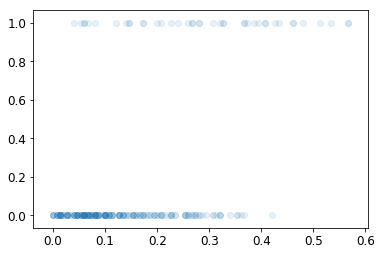

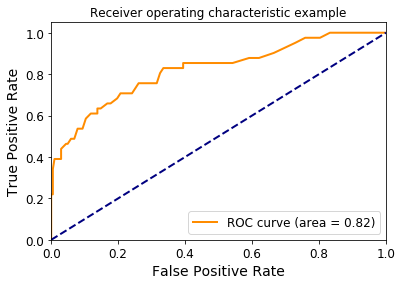

None
Set: df_raw_energy run 1 of 5 (0.902, 0.859, 0.609, 0.586, 0.755, 0.415, 1.0, 1.0, 0.415, array([[203,   0],
       [ 24,  17]]))


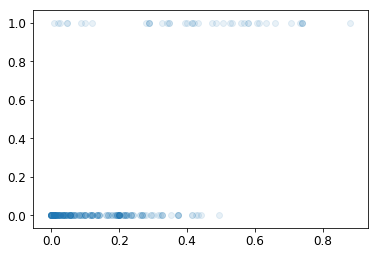

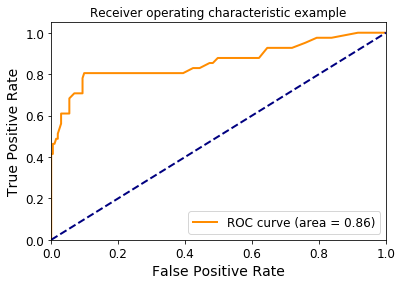

None
Set: df_raw_energy run 2 of 5 (0.885, 0.887, 0.509, 0.5, 0.705, 0.35, 0.99, 0.875, 0.35, array([[202,   2],
       [ 26,  14]]))


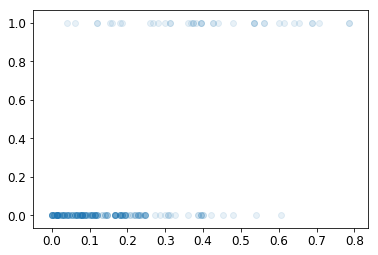

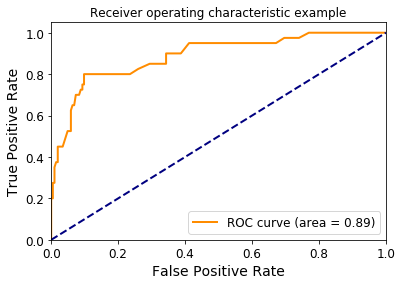

None
Set: df_raw_energy run 3 of 5 (0.824, 0.799, 0.151, 0.189, 0.434, 0.122, 0.966, 0.417, 0.122, array([[196,   7],
       [ 36,   5]]))


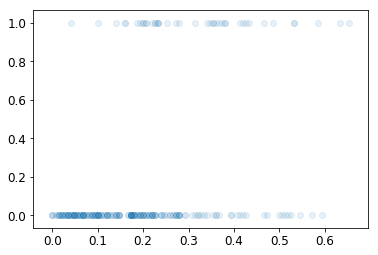

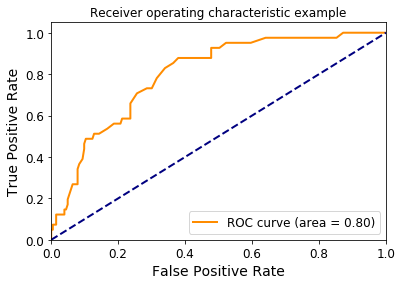

None
Set: df_raw_energy run 4 of 5 (0.828, 0.755, 0.049, 0.045, 0.408, 0.024, 0.99, 0.333, 0.024, array([[201,   2],
       [ 40,   1]]))


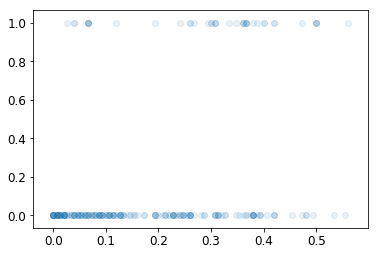

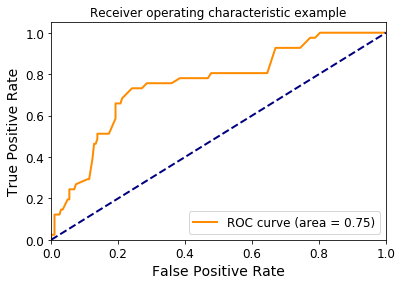

None

 df_raw_energy 
         Correc       AUC       MCC        F1       AVP       TPR     TNR  \
count  5.00000  5.000000  5.000000  5.000000  5.000000  5.000000  5.0000   
mean   0.85740  0.824000  0.321000  0.299600  0.587200  0.201800  0.9892   
std    0.03471  0.051468  0.235758  0.231314  0.157961  0.170421  0.0139   
min    0.82400  0.755000  0.049000  0.045000  0.408000  0.024000  0.9660   
25%    0.82800  0.799000  0.151000  0.178000  0.434000  0.098000  0.9900   
50%    0.84800  0.820000  0.287000  0.189000  0.634000  0.122000  0.9900   
75%    0.88500  0.859000  0.509000  0.500000  0.705000  0.350000  1.0000   
max    0.90200  0.887000  0.609000  0.586000  0.755000  0.415000  1.0000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.725000  0.201800  
std    0.324915  0.170421  
min    0.333000  0.024000  
25%    0.417000  0.098000  
50%    0.875000  0.122000  
75%    1.000000  0.350000  
max    1.000000  0.415000  
-------------
Set: df_raw_all run 0 of 5

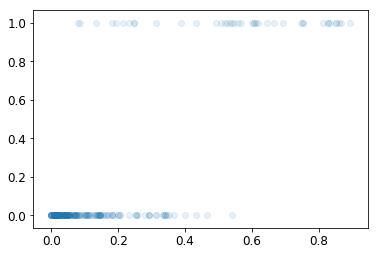

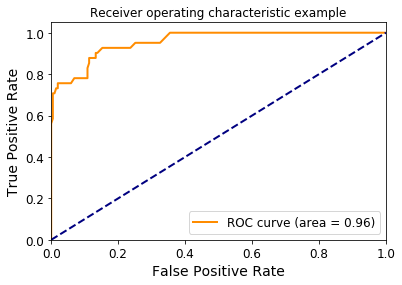

None
Set: df_raw_all run 1 of 5 (0.955, 0.96, 0.833, 0.845, 0.922, 0.732, 1.0, 1.0, 0.732, array([[203,   0],
       [ 11,  30]]))


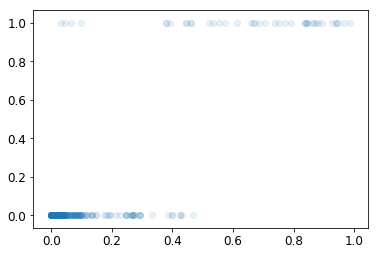

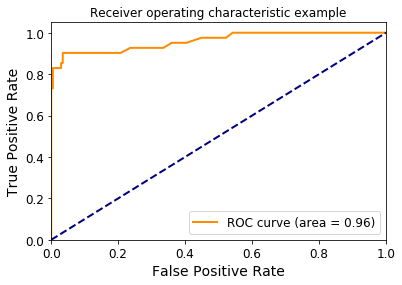

None
Set: df_raw_all run 2 of 5 (0.951, 0.916, 0.813, 0.824, 0.881, 0.7, 1.0, 1.0, 0.7, array([[204,   0],
       [ 12,  28]]))


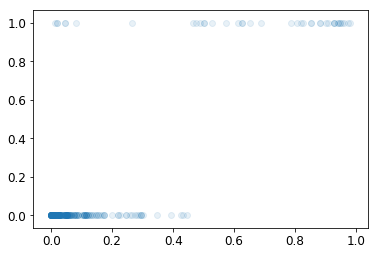

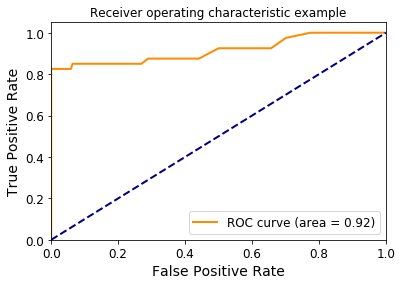

None
Set: df_raw_all run 3 of 5 (0.906, 0.954, 0.637, 0.685, 0.838, 0.61, 0.966, 0.781, 0.61, array([[196,   7],
       [ 16,  25]]))


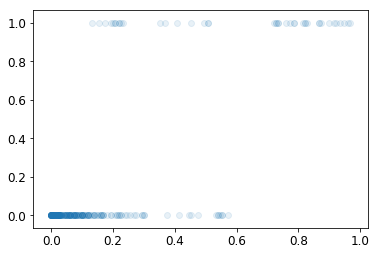

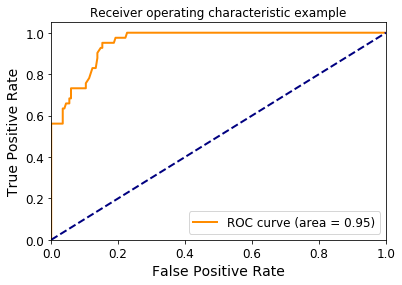

None
Set: df_raw_all run 4 of 5 (0.914, 0.957, 0.662, 0.667, 0.842, 0.512, 0.995, 0.955, 0.512, array([[202,   1],
       [ 20,  21]]))


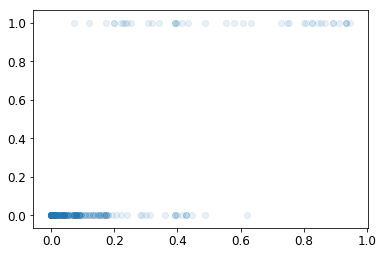

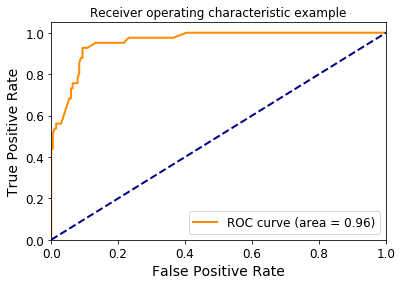

None

 df_raw_all 
          Correc       AUC       MCC        F1       AVP       TPR       TNR  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.933800  0.948800  0.745600  0.764200  0.872200  0.647400  0.991200   
std    0.022332  0.018458  0.089949  0.082321  0.034179  0.087925  0.014307   
min    0.906000  0.916000  0.637000  0.667000  0.838000  0.512000  0.966000   
25%    0.914000  0.954000  0.662000  0.685000  0.842000  0.610000  0.995000   
50%    0.943000  0.957000  0.783000  0.800000  0.878000  0.683000  0.995000   
75%    0.951000  0.957000  0.813000  0.824000  0.881000  0.700000  1.000000   
max    0.955000  0.960000  0.833000  0.845000  0.922000  0.732000  1.000000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.940400  0.647400  
std    0.091353  0.087925  
min    0.781000  0.512000  
25%    0.955000  0.610000  
50%    0.966000  0.683000  
75%    1.000000  0.700000  
max    1.000000  0.732000  
-------------
Se

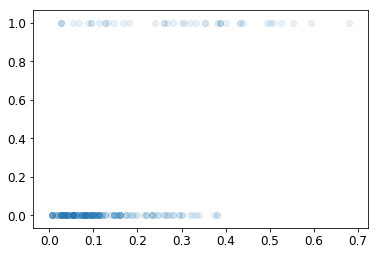

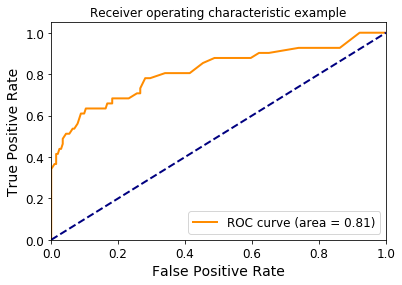

None
Set: df_raw_all_nopep run 1 of 5 (0.906, 0.937, 0.625, 0.623, 0.855, 0.463, 0.995, 0.95, 0.463, array([[202,   1],
       [ 22,  19]]))


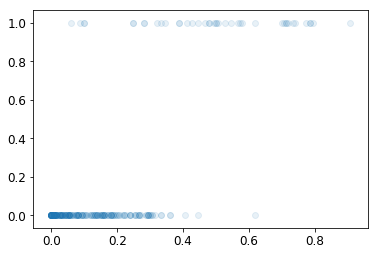

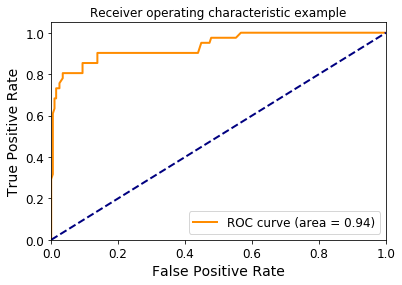

None
Set: df_raw_all_nopep run 2 of 5 (0.877, 0.889, 0.479, 0.516, 0.729, 0.4, 0.971, 0.727, 0.4, array([[198,   6],
       [ 24,  16]]))


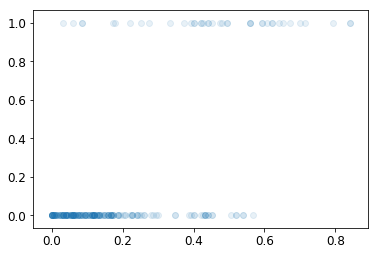

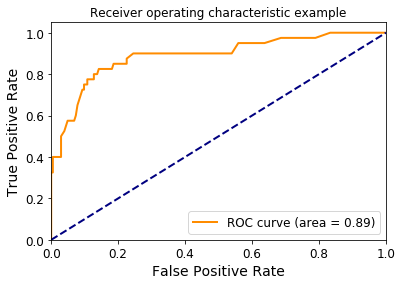

None
Set: df_raw_all_nopep run 3 of 5 (0.84, 0.844, 0.354, 0.435, 0.567, 0.366, 0.936, 0.536, 0.366, array([[190,  13],
       [ 26,  15]]))


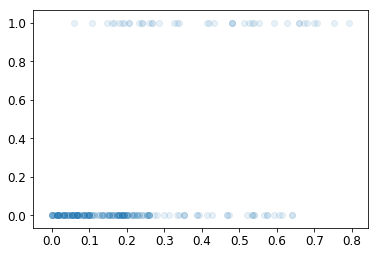

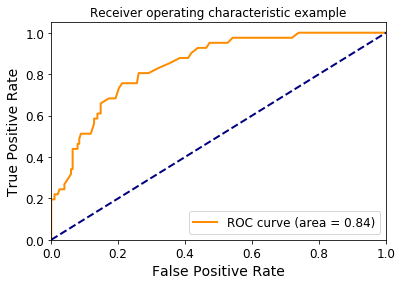

None
Set: df_raw_all_nopep run 4 of 5 (0.836, 0.797, 0.185, 0.167, 0.522, 0.098, 0.985, 0.571, 0.098, array([[200,   3],
       [ 37,   4]]))


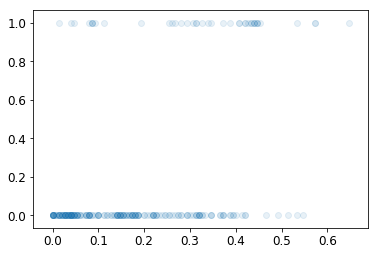

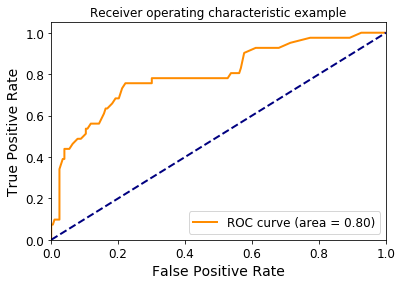

None

 df_raw_all_nopep 
          Correc      AUC       MCC       F1       AVP       TPR       TNR  \
count  5.000000  5.00000  5.000000  5.00000  5.000000  5.000000  5.000000   
mean   0.862200  0.85640  0.393000  0.39160  0.665800  0.289800  0.977400   
std    0.029244  0.05691  0.166618  0.19483  0.132596  0.167998  0.025657   
min    0.836000  0.79700  0.185000  0.16700  0.522000  0.098000  0.936000   
25%    0.840000  0.81500  0.322000  0.21700  0.567000  0.122000  0.971000   
50%    0.852000  0.84400  0.354000  0.43500  0.656000  0.366000  0.985000   
75%    0.877000  0.88900  0.479000  0.51600  0.729000  0.400000  0.995000   
max    0.906000  0.93700  0.625000  0.62300  0.855000  0.463000  1.000000   

           Prec       Rec  
count  5.000000  5.000000  
mean   0.756800  0.289800  
std    0.212506  0.167998  
min    0.536000  0.098000  
25%    0.571000  0.122000  
50%    0.727000  0.366000  
75%    0.950000  0.400000  
max    1.000000  0.463000  


In [71]:

partitions = [0, 1, 2, 3, 4]
for df, y, name in zip(dfs, ys, names):
    values = []
    print("-------------")
    for i in partitions:
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid
        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        values.append(record_stats(m)[:-3])
        print("Set:", name, "run", i, "of", partitions[-1]+1, values[-1])
        print(stat_graphs(m))

    output = pd.DataFrame(values)
    output.columns = ["Correc", "AUC", "MCC", "F1", "AVP", "TPR", "TNR", "Prec", "Rec", "Confusion"]
    print("\n", name, "\n",output.describe())

        
        
        

In [ ]:
cross_vals()

### Multipe runs, optimized hyperparams

In [334]:
values = []
partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    for runs in range(0, 5):
        #print("-------------")
        for i in partitions:
            df_trn, y_trn = df, y
            n_valid = int(len(df) / 6) # validation = 1/6th of set
            n_trn = len(df)-n_valid
            X_train, X_valid = cross_vals(df, n_trn, i)
            y_train, y_valid = cross_vals(y, n_trn, i)
            set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

            m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
            m.fit(X_train, y_train)
            values.append(no_print(m))
            #print("Set:", name, "run", i+1, "of", partitions[-1]+1, values[-1])

    output = pd.DataFrame(values)
    output.columns = ["MCC", "AP", "TPR", "TNR"]
    print("\n", name, "\n",output.describe())

        
        
        


 df_raw 
              MCC         AP        TPR        TNR
count  30.000000  30.000000  30.000000  30.000000
mean    0.801262   0.734905   0.790123   0.976525
std     0.102781   0.131292   0.099030   0.023206
min     0.677520   0.580480   0.625000   0.945810
25%     0.695220   0.599060   0.731710   0.945810
50%     0.783925   0.709640   0.768295   0.982840
75%     0.882730   0.830790   0.902440   1.000000
max     0.954770   0.937300   0.925000   1.000000

 df_raw_nopep 
              MCC         AP        TPR        TNR
count  60.000000  60.000000  60.000000  60.000000
mean    0.557598   0.507663   0.522022   0.968697
std     0.266495   0.251822   0.291058   0.030875
min     0.202280   0.208620   0.048780   0.892160
25%     0.296637   0.263482   0.292680   0.945810
50%     0.602690   0.506155   0.507620   0.980300
75%     0.781917   0.708510   0.762197   1.000000
max     0.954770   0.937300   0.925000   1.000000

 df_raw_energy 
              MCC         AP        TPR        TNR
coun

KeyboardInterrupt: 

In [335]:
dfs[0]

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
key_0,,,,,,,,,,,,,,,,,,,,,
1g6r_1p_P1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_N1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_N2_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_N3_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_R1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_S1_1t_80s_pMHC-TCR,6,-1,8,4,2,5,7,6,-1,5,...,6,6,-1,6,1,5,4,1,4,4
1g6r_1p_P1_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,6,4,6,5,5,4,4,4,4
1g6r_1p_N1_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,6,4,6,5,5,4,4,4,4
1g6r_1p_N2_1t_90s_pMHC-TCR,6,7,8,4,4,5,7,6,4,5,...,6,6,4,6,5,5,4,4,4,4


In [337]:
import random

In [375]:
#Random number 0-10
l = []
for i in range(0, 100000):
    l.append(int(random.random()*11))
pd.DataFrame(l).describe()

,0
count,100000.000000
mean,5.004760
std,3.161072
min,0.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,10.000000


In [408]:
#Random number 0-10
l = []
for i in range(0, 100000):
    l.append(random.choice(range(0,11)))
pd.DataFrame(l).describe()

,0
count,100000.000000
mean,5.012220
std,3.159771
min,0.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,10.000000


In [ ]:
random.choice(range(0,10))

In [154]:
peptide = df_raw.iloc[:, 181:191]
peptide_pos = peptide[peptide.index.str.contains("_P")]
peptide_high = peptide[peptide.index.str.contains("_N")]
peptide_low = peptide[peptide.index.str.contains("_R")]
peptide_switch = peptide[peptide.index.str.contains("_S")]

488

In [ ]:
#high + low combine

In [675]:
neg = neg.copy()
def sim_anneal(pos, neg):
    print("Before:", len(neg.index))
    for i in range(0, 1500):
        pos_np = pd.DataFrame(pos.to_numpy().flatten())
        neg_np = pd.DataFrame(neg.to_numpy().flatten())
        score_0 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
        # print("Score_0", score_0)

        choice = random.choice(neg.index)
        neg_np = pd.DataFrame(neg.drop(choice).to_numpy().flatten())
        score_1 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
        #print("Score_1", score_1)

        #print("Choice:", choice)
        delta_score = np.log(score_0) - np.log(score_1)

        if delta_score < 0:
            if ((np.exp(-delta_score/1)-1) > random.random()):
                neg = neg.drop(choice)
                print("Increased", delta_score)
        else:
            print("Decreased", delta_score)
            
    print("After:", len(neg.index))
    print(score_1)
    return(neg)

In [ ]:
peptide_high.append(peptide_low)

In [157]:
df_pos = pd.DataFrame(peptide_pos.to_numpy().flatten())
df_neg_high = pd.DataFrame(peptide_high.to_numpy().flatten())
df_neg_low = pd.DataFrame(peptide_low.to_numpy().flatten())
df_negs = pd.DataFrame(peptide_high.append(peptide_low).to_numpy().flatten())
df_switch  = pd.DataFrame(peptide_switch.to_numpy().flatten())

In [676]:
pos = peptide_pos.copy()
neg = peptide_high.copy()

In [677]:
pos_np = pd.DataFrame(pos.to_numpy().flatten())
neg_np = pd.DataFrame(neg.to_numpy().flatten())
score_0 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
print(score_0)
neg = sim_anneal(pos, neg)

4.4217061397069526e-226
Before: 732
Decreased 0.4459192957945106
Increased -0.5179443184609909
Decreased 0.007810249540170844
Decreased 0.33459968193619716
Increased -0.39808448729706924
Increased -0.7588341319941492
Decreased 0.014800383115584737
Decreased 0.2166675043296209
Increased -0.23307634506409158
Decreased 0.4450583676214137
Decreased 0.016612363465696944
Decreased 0.7288175412809323
Increased -0.1614798582641015
Increased -0.4787231728109873
Decreased 0.7293990664600187
Decreased 0.46330646813623844
Increased -0.9071101941221968
Increased -0.6460418458725599
Increased -0.7857650646487855
Decreased 0.010112820330277827
Increased -0.715198025659447
Decreased 0.44239444872130207
Decreased 0.3092816491174517
Increased -0.8461862935098452
Increased -0.46768344380336657
Increased -0.2743066891742387
Decreased 0.007441792119493584
Increased -0.27184126752121074
Increased -0.7670686641859561
Increased -0.4762819095188888
Decreased 0.5064620236332757
Increased -0.31344660988833084
De

In [678]:
pos.shape

(244, 10)

In [ ]:
len(peptide_high.append(peptide_low))

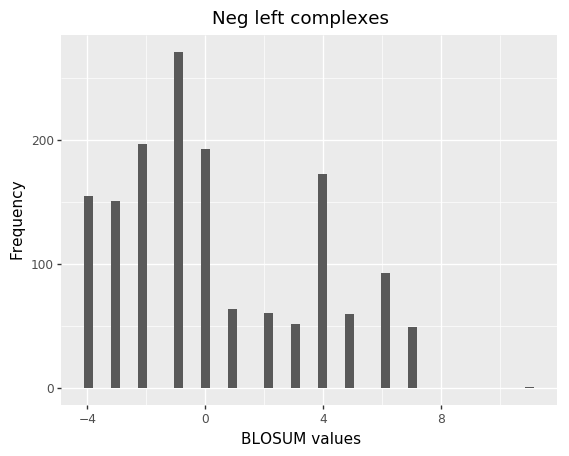

<ggplot: (-9223363246794971560)>

In [679]:
df = pd.DataFrame(neg.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Neg left complexes")
)

### Histogram shapes

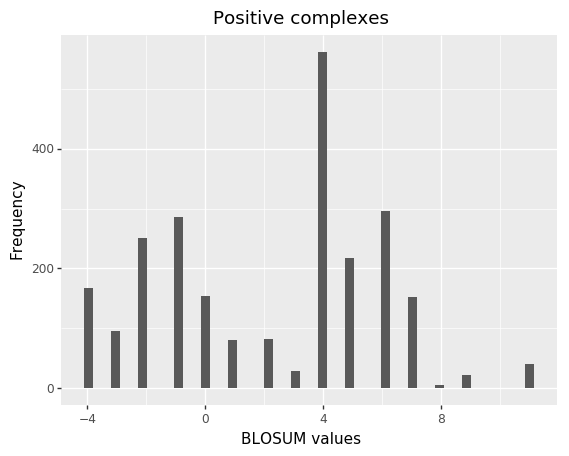

<ggplot: (8790059734427)>

In [680]:
df = pd.DataFrame(peptide_pos.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Positive complexes")
)

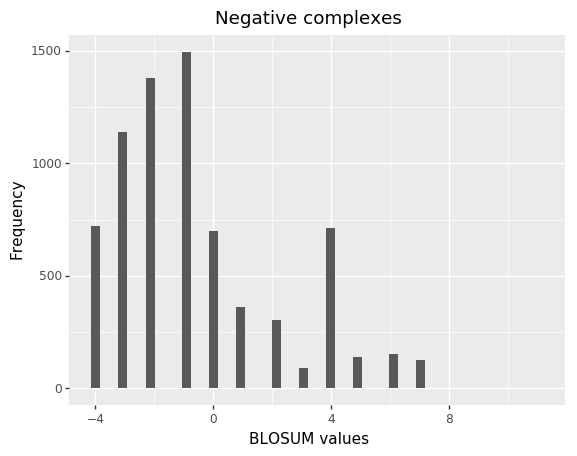

<ggplot: (8790060063019)>

In [628]:
df = pd.DataFrame(peptide_high.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Negative complexes")
)

In [ ]:
print()

In [575]:
6.060304027491623e-226*1000

6.060304027491623e-223

In [435]:
test = ["one", "two", "three", "four"]

In [463]:
choice = random.choice(neg.index)

In [467]:
neg.shape, neg.drop(choice).shape

((732, 10), (731, 10))

In [438]:
random.choice(test)

'three'

In [396]:
choice = random.choice(neg)


5

In [ ]:
df exclude positives
compariosn between MW U

sel random among negs

#SIMULATED ANNEALING

blosum pep data:

while mw (data[mask] (negs) < 0.05):

select random element
calc average all elements

choice function:
if e ^ (avg(elements) - rand.choice(element) ) / k  > random.random ({0 - 1}) 

update mask: mask = mask - selection



In [382]:
peptide_pos = pd.DataFrame(peptide_pos.to_numpy().flatten())
peptide_high = pd.DataFrame(peptide_high.to_numpy().flatten())
peptide_low = pd.DataFrame(peptide_low.to_numpy().flatten())
peptide_switch = pd.DataFrame(peptide_switch.to_numpy().flatten())

In [160]:
print("Pos vs switch:", scipy.stats.mannwhitneyu(df_pos, df_switch))
print("Pos vs high:", scipy.stats.mannwhitneyu(df_pos, df_neg_high))
print("Pos vs low:", scipy.stats.mannwhitneyu(df_pos, df_neg_low))
print("Pos vs All Negs:", scipy.stats.mannwhitneyu(df_pos, df_negs))

Pos vs switch: MannwhitneyuResult(statistic=2956362.5, pvalue=0.3376120219523998)
Pos vs high: MannwhitneyuResult(statistic=5096378.5, pvalue=4.4217061397069526e-226)
Pos vs low: MannwhitneyuResult(statistic=1815367.0, pvalue=3.8964065606371034e-125)
Pos vs All Negs: MannwhitneyuResult(statistic=6911745.5, pvalue=2.211111703497029e-230)


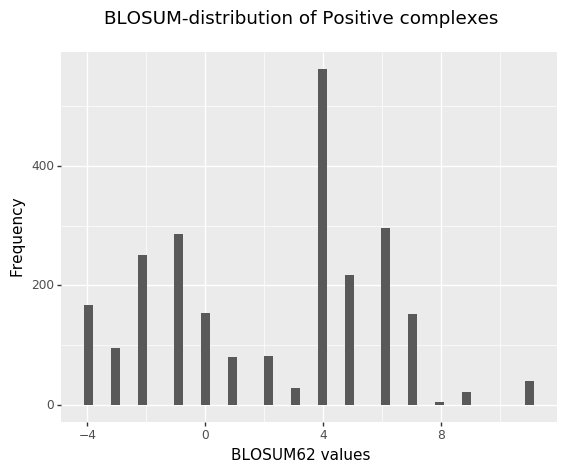

<ggplot: (-9223363247553721277)>

In [179]:
df = pd.DataFrame(df_pos)
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM62 values")
    + ylab("Frequency")
    + ggtitle("BLOSUM-distribution of Positive complexes\n")
)

In [173]:
pd.DataFrame({"Switch": pd.Series(df_switch), "Pos": pd.Series(df_pos)})

TypeError: 'int' object is not iterable

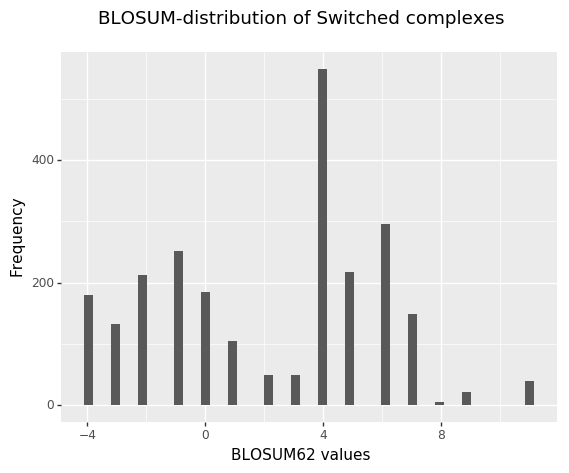

<ggplot: (-9223363247554939462)>

In [180]:
df = pd.DataFrame(df_switch)
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM62 values")
    + ylab("Frequency")
    + ggtitle("BLOSUM-distribution of Switched complexes\n")
)

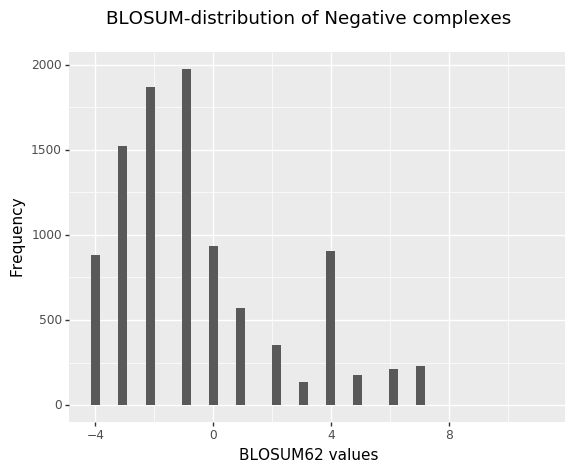

<ggplot: (-9223363247552950177)>

In [166]:
df = pd.DataFrame(df_negs)
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM62 values")
    + ylab("Frequency")
    + ggtitle("BLOSUM-distribution of Negative complexes\n")
)

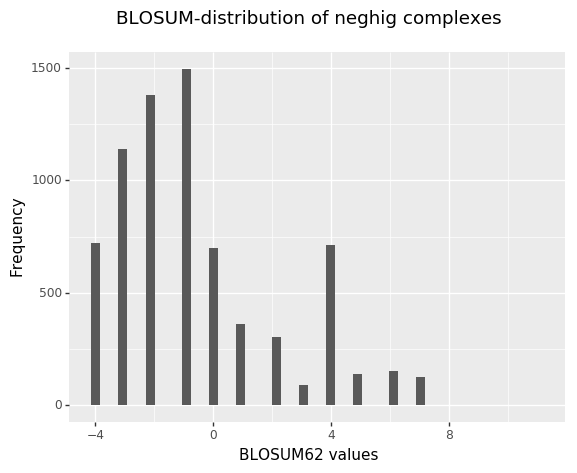

<ggplot: (8789301007922)>

In [167]:
df = pd.DataFrame(df_neg_high)
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM62 values")
    + ylab("Frequency")
    + ggtitle("BLOSUM-distribution of neghig complexes\n")
)

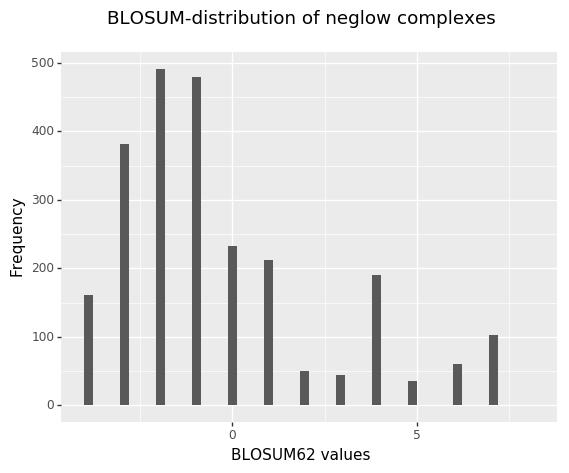

<ggplot: (8789301017506)>

In [168]:
df = pd.DataFrame(df_neg_low)
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM62 values")
    + ylab("Frequency")
    + ggtitle("BLOSUM-distribution of neglow complexes\n")
)